# Un arbre de décision en réseaux de neurones

L'idée est de convertir sous la forme d'un réseaux de neurones un arbre de décision puis de continuer l'apprentissage de façon à obtenir un assemblage de régression logistique plutôt que de décision binaire.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline
from jyquickhelper import RenderJsDot
import numpy
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm

## Un exemple sur Iris

La méthode ne marche sur un problème de classification binaire.

In [3]:
from sklearn.datasets import load_iris
data = load_iris()
X, y = data.data[:, :2], data.target
y = y % 2

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

In [5]:
from sklearn.tree import DecisionTreeClassifier
dec = DecisionTreeClassifier(max_depth=2, random_state=11)
dec.fit(X_train, y_train)
dec.score(X_test, y_test)

0.6052631578947368

In [6]:
from sklearn.tree import export_graphviz
dot = export_graphviz(dec, filled=True)
dot = dot.replace("shape=box, ", "shape=box, fontsize=10, ")
RenderJsDot(dot)

## Même exemple en réseau de neurones

In [7]:
from mlstatpy.ml.neural_tree import NeuralTreeNet
net = NeuralTreeNet.create_from_tree(dec)
RenderJsDot(net.to_dot())

On considère une entrée en particulier.

In [8]:
n = 60
dec.predict_proba(X[n: n+1])

array([[0.27906977, 0.72093023]])

In [9]:
RenderJsDot(net.to_dot(X=X[n]))

In [10]:
dec.predict_proba(X_test)[:5]

array([[0.75      , 0.25      ],
       [0.75      , 0.25      ],
       [0.27906977, 0.72093023],
       [1.        , 0.        ],
       [0.27906977, 0.72093023]])

In [11]:
net.predict(X_test)[:5, -2:]

array([[0.79156817, 0.20843183],
       [0.73646978, 0.26353022],
       [0.29946111, 0.70053889],
       [0.94070094, 0.05929906],
       [0.24924737, 0.75075263]])

In [12]:
dec.predict_proba(X_test)[-5:]

array([[1.  , 0.  ],
       [0.75, 0.25],
       [1.  , 0.  ],
       [0.75, 0.25],
       [0.75, 0.25]])

In [13]:
net.predict(X_test)[-5:, -2:]

array([[0.93247891, 0.06752109],
       [0.86338585, 0.13661415],
       [0.98219036, 0.01780964],
       [0.98352807, 0.01647193],
       [0.73646978, 0.26353022]])

In [14]:
numpy.argmax(net.predict(X_test)[-5:, -2:], axis=1)

array([0, 0, 0, 0, 0], dtype=int64)

c:\python372_x64\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()


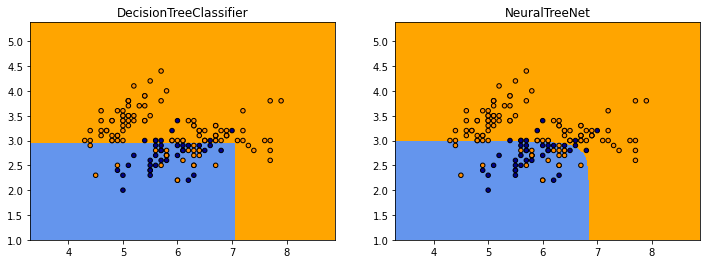

In [15]:
def plot_grid(X, y, fct, title, ax=None):
    
    cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
    cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])    

    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, h),
                            numpy.arange(y_min, y_max, h))
    Z = fct(numpy.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    if ax is None:
        _, ax = plt.subplots(1, 1)
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)

    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(title)


fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_grid(X, y, dec.predict, dec.__class__.__name__, ax=ax[0])
plot_grid(X, y,
          lambda x: numpy.argmax(net.predict(x)[:, -2:], axis=1),
          net.__class__.__name__, ax=ax[1])

Le code qui produit les prédictions du réseau de neurones est assez long à exécuter mais il produit à peu près les mêmes frontières excepté qu'elles sont plus arrondies.

## Intermède de simples neurones de régression

Avant d'apprendre ou plutôt de continuer l'apprentissage des coefficients du réseaux de neurones, voyons comment un neurone se débrouille sur un problème de régression.

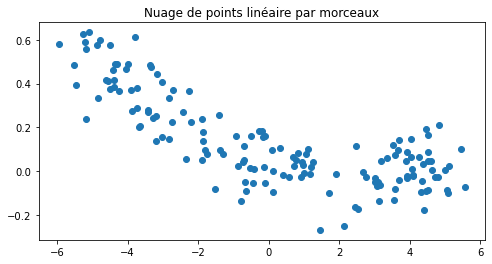

In [16]:
regX = numpy.empty((150, 1), dtype=numpy.float64)
regX[:50, 0] = numpy.random.randn(50) - 4
regX[50:100, 0] = numpy.random.randn(50)
regX[100:, 0] = numpy.random.randn(50) + 4
noise = numpy.random.randn(regX.shape[0]) / 10
regY = regX[:, 0] * -0.5 * 0.2 + noise
regY[regX[:, 0] > 0.3] = noise[regX[:, 0] > 0.3]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(regX[:, 0], regY)
ax.set_title("Nuage de points linéaire par morceaux");

On cale une régression avec *scikit-learn*.

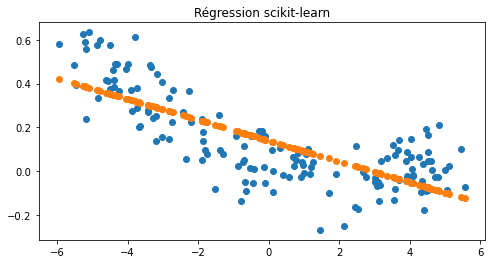

In [17]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(regX, regY)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(regX[:, 0], regY)
ax.scatter(regX[:, 0], lr.predict(regX))
ax.set_title("Régression scikit-learn");

Et maintenant un neurone avec une fonction d'activation "identity".

In [18]:
from mlstatpy.ml.neural_tree import NeuralTreeNode
neu = NeuralTreeNode(1, activation="identity")
neu

NeuralTreeNode(weights=array([0.08929469]), bias=0.20406858185218837, activation='identity')

In [19]:
neu.fit(regX, regY, verbose=True, max_iter=20)

0/20: loss: 34.9 lr=0.002 max(coef): 0.2041
1/20: loss: 2.917 lr=0.000163 max(coef): 0.1677
2/20: loss: 2.724 lr=0.000115 max(coef): 0.1691
3/20: loss: 2.704 lr=9.42e-05 max(coef): 0.1628
4/20: loss: 2.639 lr=8.16e-05 max(coef): 0.156
5/20: loss: 2.619 lr=7.3e-05 max(coef): 0.1526
6/20: loss: 2.686 lr=6.66e-05 max(coef): 0.1505
7/20: loss: 2.623 lr=6.17e-05 max(coef): 0.1502
8/20: loss: 2.646 lr=5.77e-05 max(coef): 0.1481
9/20: loss: 2.605 lr=5.44e-05 max(coef): 0.1492
10/20: loss: 2.614 lr=5.16e-05 max(coef): 0.1486
11/20: loss: 2.636 lr=4.92e-05 max(coef): 0.1474
12/20: loss: 2.593 lr=4.71e-05 max(coef): 0.1449
13/20: loss: 2.642 lr=4.53e-05 max(coef): 0.1427
14/20: loss: 2.595 lr=4.36e-05 max(coef): 0.14
15/20: loss: 2.59 lr=4.22e-05 max(coef): 0.1383
16/20: loss: 2.592 lr=4.08e-05 max(coef): 0.1389
17/20: loss: 2.589 lr=3.96e-05 max(coef): 0.1376
18/20: loss: 2.591 lr=3.85e-05 max(coef): 0.1377
19/20: loss: 2.603 lr=3.75e-05 max(coef): 0.1371
20/20: loss: 2.593 lr=3.65e-05 max(coef

NeuralTreeNode(weights=array([-0.0457791]), bias=0.1380769447709318, activation='identity')

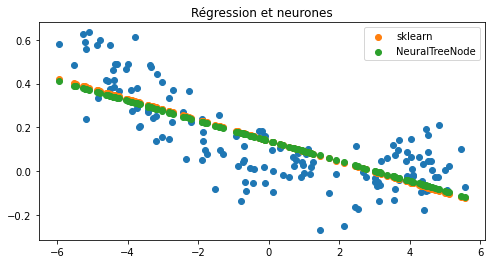

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(regX[:, 0], regY)
ax.scatter(regX[:, 0], lr.predict(regX), label="sklearn")
ax.scatter(regX[:, 0], neu.predict(regX), label="NeuralTreeNode")
ax.legend()
ax.set_title("Régression et neurones");

Et avec d'autres fonctions d'activation...

In [21]:
neus = {'identity': neu}
for act in tqdm(['relu', 'leakyrelu', 'sigmoid']):
    nact = NeuralTreeNode(1, activation=act)
    nact.fit(regX, regY)
    neus[act] = nact

100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


In [22]:
neus['relu'], neus['leakyrelu']

(NeuralTreeNode(weights=array([0.29289871]), bias=-1.8478825257206628, activation='relu'),
 NeuralTreeNode(weights=array([-0.18223211]), bias=-0.34877782929668666, activation='leakyrelu'))

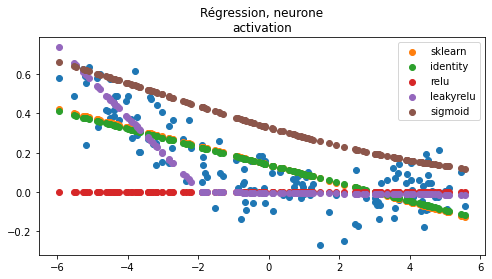

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(regX[:, 0], regY)
ax.scatter(regX[:, 0], lr.predict(regX), label="sklearn")
for k, v in neus.items():
    ax.scatter(regX[:, 0], v.predict(regX), label=k)
ax.legend()
ax.set_title("Régression, neurone\nactivation");

Rien de surprenant. La fonction sigmoïde prend ses valeurs entre 0 et 1. La fonction *relu* est parfois nulle sur une demi-droite, dès que la fonction est nulle sur l'ensemble du nuage de points, le gradient est nul partout (voir [Rectifier (neural networks)](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))). La fonction leaky relu est définie comme suit :

$$f(x) = \left\{\begin{array}{l} x \, si \, x > 0 \\ \frac{x}{100} \, sinon \end{array}\right.$$

Le gradient n'est pas nul sur la partie la plus plate.

## Intermède de simples neurones de classification

Avant d'apprendre ou plutôt de continuer l'apprentissage des coefficients du réseaux de neurones, voyons comment un neurone se débrouille sur un problème de classification.

In [24]:
from sklearn.linear_model import LogisticRegression


clsX = numpy.empty((100, 2), dtype=numpy.float64)
clsX[:50] = numpy.random.randn(50, 2)
clsX[50:] = numpy.random.randn(50, 2) + 2
clsy = numpy.zeros(100, dtype=numpy.int64)
clsy[50:] = 1

logr = LogisticRegression()
logr.fit(clsX, clsy)
pred1 = logr.predict(clsX)

In [25]:
def line_cls(x0, x1, coef, bias):
    y0 = -(coef[0,0] * x0 + bias) / coef[0,1]
    y1 = -(coef[0,0] * x1 + bias) / coef[0,1]
    return x0, y0, x1, y1

x0, y0, x1, y1 = line_cls(-5, 5, logr.coef_, logr.intercept_)

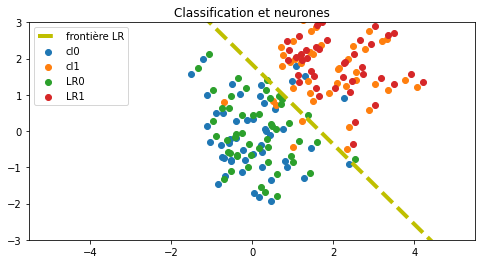

In [26]:
h = 0.15
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(clsX[clsy == 0, 0], clsX[clsy == 0, 1], label='cl0')
ax.scatter(clsX[clsy == 1, 0], clsX[clsy == 1, 1], label='cl1')
ax.scatter(clsX[pred1 == 0, 0] + h, clsX[pred1 == 0, 1] + h, label='LR0')
ax.scatter(clsX[pred1 == 1, 0] + h, clsX[pred1 == 1, 1] + h, label='LR1')
ax.plot([x0, x1], [y0, y1], 'y--', lw=4, label='frontière LR')
ax.set_ylim([-3, 3])
ax.legend()
ax.set_title("Classification et neurones");

Un neurone de classification binaire produit deux sorties, une pour chaque classe, et sont normalisées à 1. La fonction d'activation est la fonction [softmax](https://en.wikipedia.org/wiki/Softmax_function).

In [27]:
clsY = numpy.empty((clsy.shape[0], 2), dtype=numpy.float64)
clsY[:, 1] = clsy
clsY[:, 0] = 1 - clsy

In [28]:
softneu = NeuralTreeNode(2, activation='softmax')
softneu

NeuralTreeNode(weights=array([[ 1.45914023, -1.56447803],
       [ 0.73841975, -0.7044818 ]]), bias=array([-0.36979959, -1.03256423]), activation='softmax')

In [29]:
softneu.fit(clsX, clsY, verbose=True, max_iter=20, lr=0.001)

0/20: loss: 679.7 lr=0.001 max(coef): 1.564
1/20: loss: 209.1 lr=9.95e-05 max(coef): 5.468
2/20: loss: 200.4 lr=7.05e-05 max(coef): 6.43
3/20: loss: 195.3 lr=5.76e-05 max(coef): 6.829
4/20: loss: 194.4 lr=4.99e-05 max(coef): 7.162
5/20: loss: 192.2 lr=4.47e-05 max(coef): 7.456
6/20: loss: 191.4 lr=4.08e-05 max(coef): 7.707
7/20: loss: 190.2 lr=3.78e-05 max(coef): 7.936
8/20: loss: 189.6 lr=3.53e-05 max(coef): 8.14
9/20: loss: 188.8 lr=3.33e-05 max(coef): 8.335
10/20: loss: 187.9 lr=3.16e-05 max(coef): 8.519
11/20: loss: 186.4 lr=3.01e-05 max(coef): 8.7
12/20: loss: 185.3 lr=2.89e-05 max(coef): 8.877
13/20: loss: 185.3 lr=2.77e-05 max(coef): 9.024
14/20: loss: 185.1 lr=2.67e-05 max(coef): 9.171
15/20: loss: 184.7 lr=2.58e-05 max(coef): 9.321
16/20: loss: 184.2 lr=2.5e-05 max(coef): 9.459
17/20: loss: 184 lr=2.42e-05 max(coef): 9.589
18/20: loss: 183.2 lr=2.36e-05 max(coef): 9.724
19/20: loss: 182.5 lr=2.29e-05 max(coef): 9.853
20/20: loss: 182.6 lr=2.24e-05 max(coef): 9.965


NeuralTreeNode(weights=array([[6.91805573, 3.01514051],
       [9.37342443, 5.74888435]]), bias=array([9.96519505, 6.80763205]), activation='softmax')

In [30]:
pred = softneu.predict(clsX)
pred[:5]

array([[0.99588377, 0.00411623],
       [0.99878918, 0.00121082],
       [0.93316341, 0.06683659],
       [0.89966574, 0.10033426],
       [0.75010727, 0.24989273]])

In [31]:
pred2 = (pred[:, 1] > 0.5).astype(numpy.int64)

In [32]:
x00, y00, x01, y01 = line_cls(-4, 4, softneu.coef[:1, 1:], softneu.bias[0])
x10, y10, x11, y11 = line_cls(-4, 4, softneu.coef[1:, 1:], softneu.bias[1])
xa, ya, xb, yb = line_cls(
    -5, 5, softneu.coef[1:, 1:] - softneu.coef[:1, 1:],
    softneu.bias[1] - softneu.bias[0])

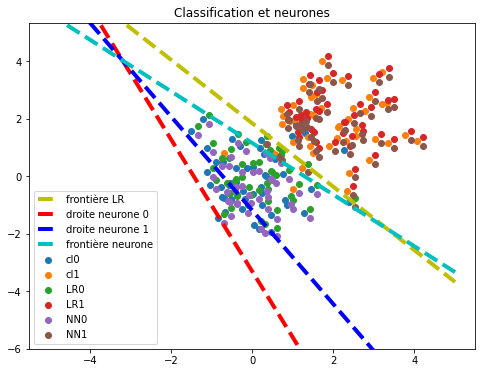

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(clsX[clsy == 0, 0], clsX[clsy == 0, 1], label='cl0')
ax.scatter(clsX[clsy == 1, 0], clsX[clsy == 1, 1], label='cl1')
ax.scatter(clsX[pred1 == 0, 0] + h, clsX[pred1 == 0, 1] + h, label='LR0')
ax.scatter(clsX[pred1 == 1, 0] + h, clsX[pred1 == 1, 1] + h, label='LR1')
ax.scatter(clsX[pred2 == 0, 0] + h, clsX[pred2 == 0, 1] - h, label='NN0')
ax.scatter(clsX[pred2 == 1, 0] + h, clsX[pred2 == 1, 1] - h, label='NN1')
ax.plot([x0, x1], [y0, y1], 'y--', lw=4, label='frontière LR')
ax.plot([x00, x01], [y00, y01], 'r--', lw=4, label='droite neurone 0')
ax.plot([x10, x11], [y10, y11], 'b--', lw=4, label='droite neurone 1')
ax.plot([xa, xb], [ya, yb], 'c--', lw=4, label='frontière neurone')
ax.set_ylim([max(-6, min([-3, y10, y11, y11, y01])),
             min(6, max([3, y10, y11, y11, y01]))])
ax.legend()
ax.set_title("Classification et neurones");

Ca marche. On vérifie en calculant le score. Le neurone a deux sorties. La frontière est définie par l'ensemble des points pour lesquels les deux sorties sont égales. Par conséquent, la distance entre les deux droites définies par les coefficients du neurone doivent être égales. Il existe une infinité de solutions menant à la même frontière.

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(clsy, logr.predict_proba(clsX)[:, 1])

0.966

In [35]:
roc_auc_score(clsy, softneu.predict(clsX)[:, 1])

0.9676

## Apprentissage du réseau de neurones

Maintenant qu'on a vu les différentes fonctions d'activations et leur application sur des problèmes simples, on revient aux arbres convertis sous la forme d'un réseau de neurones. La prochaine étape est de pouvoir améliorer les performances du modèle issu de la conversion d'un arbre de classification avec un algorithme du gradient.